In [332]:
import os

import numpy as np
import pandas as pd
from pandas.api.types import is_numeric_dtype

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression

from IPython.display import display, HTML

import warnings
warnings.filterwarnings('ignore')

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

# source: https://stackoverflow.com/a/28073228/4463701

<h1><center>Conversion Analysis of the AirBnB Dataset</h1>

I chose to analyze the [AirBnB sessions dataset](https://raw.githubusercontent.com/curran/data/gh-pages/airbnb/airbnb_session_data.txt) that was used in the [Pathways visualization challenge](http://databits.io/challenges/airbnb-user-pathways-challenge). I performed exploratory data analysis and then fit an elastic-net logistic regression model to the data to analyze the independent effects of the features on conversion.

The dataset contains 21 features in rows that are essentially two observations, the "first" and "next" sessions. 10 of them correspond the the visitor id's first session, and 10 of them correspond the next session.

In [334]:
raw_df = pd.read_csv('https://raw.githubusercontent.com/curran/data/gh-pages/airbnb/airbnb_session_data.txt',
                    sep='|')
raw_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7756 entries, 0 to 7755
Data columns (total 21 columns):
id_visitor                   7756 non-null object
id_session                   7756 non-null object
dim_session_number           7756 non-null int64
dim_user_agent               7537 non-null object
dim_device_app_combo         7756 non-null object
ds                           7756 non-null object
ts_min                       7756 non-null object
ts_max                       7756 non-null object
did_search                   7756 non-null int64
sent_message                 7756 non-null int64
sent_booking_request         7756 non-null int64
next_id_session              7126 non-null object
next_dim_session_number      7126 non-null float64
next_dim_user_agent          6927 non-null object
next_dim_device_app_combo    7126 non-null object
next_ds                      7126 non-null object
next_ts_min                  7126 non-null object
next_ts_max                  7126 non-null obj

<h2><center>Relationships between the First and Next Sessions</h2>

First, I considered exploring the relationship between the first and next sessions. 

However, as the correlation plot shows, there is not very much correlation between the numeric features of the first and next sessions. I observed the following:

- There is moderate correlation between visitors who searched during each section.

- However, the other correlations are so close to zero that further analysis of the first and next session differences is unlikely to yield interesting results.

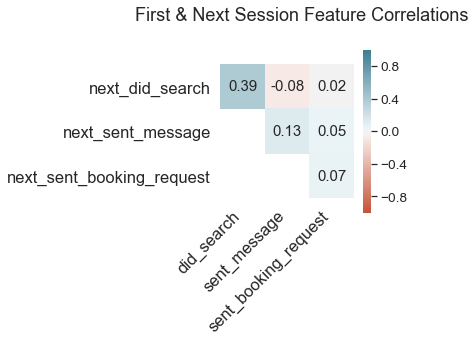

In [347]:
# get columns
flag_columns = pd.Series(['did_search', 'sent_message', 'sent_booking_request'])
next_flag_columns = "next_" + flag_columns
all_flag_columns = flag_columns.append(next_flag_columns)

# create correlations
corr_df = raw_df[all_flag_columns].corr().loc[next_flag_columns][flag_columns]
mask = np.ones(corr_df.shape, dtype='bool')
mask[np.triu_indices(len(corr_df))] = False

# plot correlations
fig, ax = plt.subplots(figsize=(3, 3))
sns.set(font_scale=1.25)
sns.heatmap(
    corr_df, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True,
    annot=True, 
    fmt='.2f', 
    mask=mask
) 
fig.suptitle('First & Next Session Feature Correlations', y=1.08)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
)
ax.patch.set_visible(False)


<h2><center>Creating the Sessions Dataset</center></h2>

Instead, I stacked the first and next session features into a "sessions" dataset and decided to analyze the session attributes that are associated with AirBnB conversions, represented by the `sent_booking_request` column.

Here are some of the other transformations I performed during the stacking process:

- Removed the "next" sessions where a session did not occur. After this, the dataset did not have any missing values.
- Added a column called `is_next_session` as a feature.
- Dropped the `dim_user_agent` column since the device and app information was already extracted.

In [349]:
# create DF to hold the "next" session features, remove the rows where a session didn't occur (is_session is null) 
next_columns = raw_df.columns.str.contains('^next_')
next_columns[0] = True
next_df = raw_df.loc[raw_df.next_id_session.notnull(), next_columns].assign(is_next_session = 1)

# create DF to hold the "first" session features
next_columns[0] = False
non_next_df = raw_df.loc[:, ~next_columns].assign(is_next_session = 0)

next_df.set_axis(non_next_df.columns, axis=1, inplace=True)

# combine the sessions into 1 df, drop dim_user_agent
all_sessions_df = pd.concat([non_next_df, next_df], axis=0, ignore_index=True)\
    .drop('dim_user_agent', axis=1)

print(all_sessions_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14882 entries, 0 to 14881
Data columns (total 11 columns):
id_visitor              14882 non-null object
id_session              14882 non-null object
dim_session_number      14882 non-null float64
dim_device_app_combo    14882 non-null object
ds                      14882 non-null object
ts_min                  14882 non-null object
ts_max                  14882 non-null object
did_search              14882 non-null float64
sent_message            14882 non-null float64
sent_booking_request    14882 non-null float64
is_next_session         14882 non-null int64
dtypes: float64(4), int64(1), object(6)
memory usage: 1.2+ MB
None


<h2><center>Feature Engineering</center></h2>

Next, I engineered the following features using the session date and timestamps:

- `session_minutes` (continuous): I wanted to know whether the session duration was related to conversion.
- `month` (categorical):  The travel/hospitality business is seasonal, and I wanted to know if conversion was more likely during certain months.
- `day_of_week` (categorical): I wanted to know how if conversion was more likely to occur on certain days of the week.
- `hour_of_day` (categorical):  I wanted to know how if conversion was more likely to occur at certain hours of the day.
- `year` (categorical): I wanted to see how the two years in the dataset affected conversion.
- `day_number`(integers): I wanted to know if conversion changed as the AirBnB business matured.

In [351]:
# cast objects to datetime dtype
features_df = \
    all_sessions_df.assign(
    
        ts_min = pd.to_datetime(all_sessions_df.ts_min),
        ts_max = pd.to_datetime(all_sessions_df.ts_max),
        ds = pd.to_datetime(all_sessions_df.ds),
    
    )

# split_dim_device_app_combo = features_df.dim_device_app_combo.str.split(' - ', expand=True)

features_df = \
    features_df.assign(

        session_minutes = (features_df.ts_max - features_df.ts_min).astype('timedelta64[m]'),
        day_number = (features_df.ds - features_df.ds.min()).astype('timedelta64[D]'),
        # day_of_month = features_df.ts_min.dt.day.astype('category'),
        day_of_week = features_df.ts_min.dt.day_name().astype('category'),
        hour_of_day = features_df.ts_min.dt.hour.astype('category'),
        month = features_df.ts_min.dt.month.astype('category'),
        year = features_df.ts_min.dt.year.astype('category') #,
#       device = split_dim_device_app_combo.loc[:, 0],
#       app = split_dim_device_app_combo.loc[:, 1]
        
    ).drop(['ds', 'ts_min', 'ts_max', 'id_session', 'id_visitor'], axis=1)

# change all objects to categories
features_df.loc[:, features_df.dtypes == 'object'] =\
    features_df.select_dtypes(['object'])\
    .apply(lambda x: x.astype('category'))

# features_df.info()

<h2><center>Exploratory Data Analysis</center></h2>

In the plots below, I examined the top 10 most frequent values for each variable. For the categorical variables, the most frequent value will be used as the reference level in the subsequent model. 

I observed the following:

- The `did_search`, `sent_message` and the response variable `sent_booking_request` exhibit extreme class imbalances. `sent_booking_request` has the most extreme imbalance with only 1.9% of the observations representing the positive class. 

- The most sessions occurred on Mondays (`day_of_week`)

- The most common device-app combo was the iPhone/iPhone app (`dim_device_app_combo`). This combo had more than twice the sessions as the next most frequent value.

- The most common month was September, followed by December (`month`)

- More than one third of all sessions lasted for 0 seconds, which helps explain why conversion is such a rare event (`session_minutes`)


In [427]:
# get the top x values for each feature
top_x_values =\
    features_df\
        .melt()\
        .groupby(['variable', 'value'])['value']\
        .agg('count')\
        .to_frame()\
        .rename(index=str, columns={'value': 'value_count'})\
        .reset_index()\
        .groupby(['variable'])\
        .apply(lambda x: x.nlargest(10, 'value_count'))\
        .reset_index(drop=True)\
        .sort_values(['variable', 'value_count'])


top_x_values['value'] = top_x_values.value.str.replace(' ', '').str.slice(stop=15)

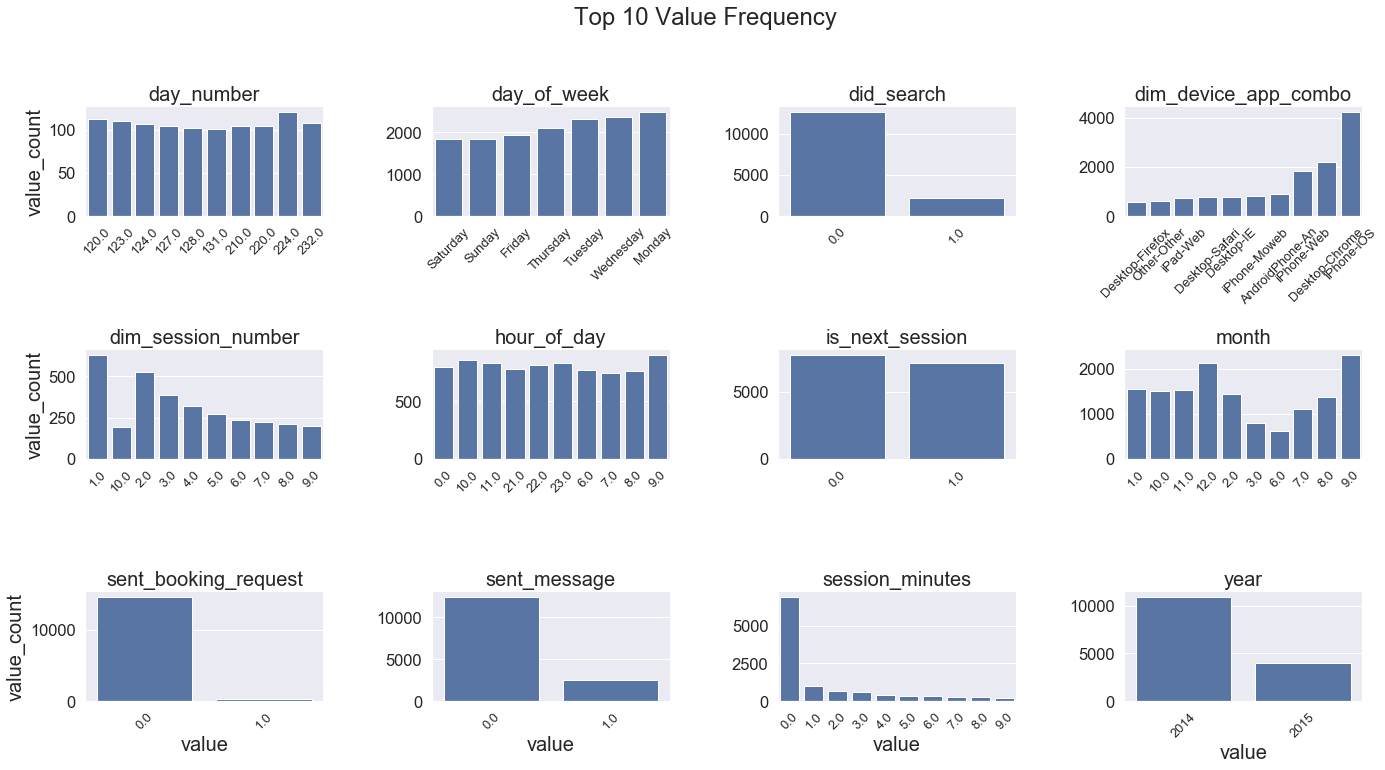

In [428]:
# facet barplots
plt.rcParams["axes.labelsize"] = 20
g = sns.FacetGrid(top_x_values, 
                  col="variable", 
                  col_wrap=4, 
                  sharey=False, 
                  sharex=False)

g.fig.set_figwidth(20)
g.fig.set_figheight(10)


for ax in g.axes.flat:
    for label in ax.get_xticklabels():
        label.set_rotation(45)
        label.set_fontsize(13)

g.map(sns.barplot, 'value', 'value_count')
g.set_titles('{col_name}')
t = g.fig.suptitle('Top 10 Value Frequency', y=1.08)

In the correlation plot below, I observed the following:

- None of the features exhibit even a moderate amount of correlation. 

- The response variable `sent_booking_request` is the most correlated with `sent_messages` and `did_search`. However, the relationships are weak, and fitting a predictive conversion model to the data is likely to be challenging.

In [375]:
numeric_feature_corr = features_df.loc[:, features_df.apply(is_numeric_dtype)].corr()  
mask = np.zeros_like(numeric_feature_corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

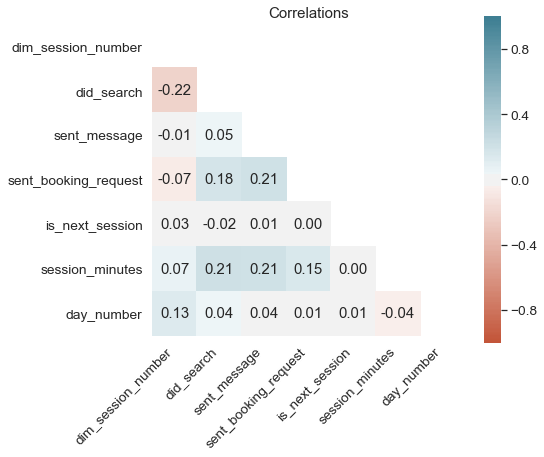

In [381]:
sns.set(font_scale=1.25)
fig, ax = plt.subplots(figsize=(7, 6))
sns.heatmap(
    numeric_feature_corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True,
    annot=True, 
    fmt='.2f', 
    mask=mask
).set_title('Correlations')

ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
)
ax.patch.set_visible(False)

# source: https://towardsdatascience.com/better-heatmaps-and-correlation-matrix-plots-in-python-41445d0f2bec

In [221]:
features_df_melted = \
    pd.melt(features_df[['dim_session_number','session_minutes','day_number', 'sent_booking_request']],
        id_vars='sent_booking_request')

The boxplots below show the numeric-feature distributions across the 2 response variable classes. 

- The distributions for `dim_session_number` and `session_minutes` are visually different. Higher daily session counts are more associated with not converting, and longer session durations are associated with converting. 

- The distributions for the `day_number` feature exhibit nearly no difference.

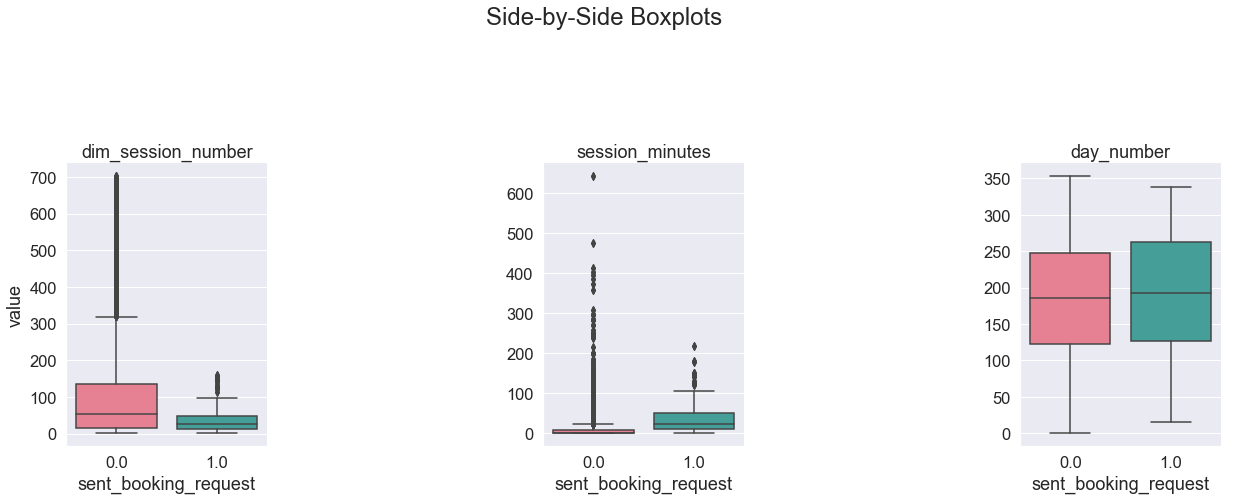

In [387]:
plt.rcParams.update({'font.size': 20})

g = sns.catplot(col="variable", 
                y='value',
                x="sent_booking_request",
                data=features_df_melted,
                sharey=False,
                palette="husl", 
                col_wrap=3,
                kind="box",
                height=3)

g.fig.set_figwidth(20)
g.fig.set_figheight(8)
g.set_titles('{col_name}')
t = g.fig.suptitle('Side-by-Side Boxplots', y=1.08)

<h2><center>Logistic Regression Model</center></h2>

Finally, I fit logistic regression model to the data to understand the independent effects of each feature. I used the elastic-net version to eliminate features that are not predictive of conversion and to remove any collinearity between the features. 

After regularizing the C and alpha parameters as well as tuning the class weights, the best model achieved an F1 score of 0.41 for the positive class on the withheld test dataset. Recall was higher than precision, which means that there were more false positives than false negatives.




In [299]:
# change all binary flags to categories, except for the label
binary_flag_cols = (features_df.nunique() == 2) & (features_df.columns != 'sent_booking_request')
features_df.loc[:, binary_flag_cols] =\
    features_df.loc[:, binary_flag_cols]\
    .apply(lambda x: x.astype('category'))

final_features_df = features_df.copy()

RANDOM_STATE = 5
FOLDS = 5
TEST_SIZE = 0.2

# get the labels
all_labels = final_features_df.sent_booking_request
final_features_df.drop('sent_booking_request', axis=1, inplace=True)

# split data, keep the labels as numeric values
train_features, test_features, train_labels, test_labels =\
    train_test_split(final_features_df, 
                     all_labels, 
                     test_size=TEST_SIZE, 
                     random_state=RANDOM_STATE
                    )

In [224]:
# Create the Pipeline
numeric_features = final_features_df.columns[final_features_df.dtypes == 'float64']
categorical_features = final_features_df.columns[final_features_df.dtypes == 'category']

x_nums = pd.Series('x').repeat(len(categorical_features)).str.cat(pd.Series(range(len(categorical_features))).astype('str'))
categorical_feature_dict = dict(zip(x_nums, categorical_features))

reference_levels = final_features_df[categorical_features].apply(lambda x: x.value_counts().index[0])
reference_level_dict = dict(zip(categorical_features, reference_levels))

# create transformers
numeric_transformer = Pipeline(steps=[('scaler', StandardScaler())])       
categorical_transformer = Pipeline(steps=[('one_hot', OneHotEncoder(drop=reference_levels))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)]
)

# source: https://scikit-learn.org/stable/auto_examples/compose/plot_column_transformer_mixed_types.html


In [ ]:
# create stratified folds
skf = StratifiedKFold(n_splits=FOLDS, random_state=RANDOM_STATE)

param_grid = {
    
    'model__solver': ['saga'],
    'model__C':  np.logspace(-3, -1, 6),
    'model__l1_ratio': np.linspace(.5, 1, 6), #np.linspace(0, 1, 6),
    'model__penalty': ['elasticnet'], 
    'model__class_weight': [{0: 1, 1: 10}], #{0: 1, 1: 6} {0: 1, 1: 12}, None, 'balanced', {0: 1, 1: 25}
    'model__warm_start': [True], # False
    'model__max_iter': [300] #200, 400
    
}

model = LogisticRegression(
    
    verbose=0,
    random_state=RANDOM_STATE,
    n_jobs=-1

)

steps = [
    ('preprocessor', preprocessor),
    ('model', model)
]

# Instantiate pipeline
pipeline = Pipeline(steps)

# fit model pipeline
cv_model = GridSearchCV(pipeline, param_grid, cv=skf, n_jobs=-1, verbose=2, scoring='f1')
cv_model.fit(train_features, train_labels)


In [429]:
# predict
test_pred = cv_model.predict(test_features)
print(classification_report(test_labels, test_pred))


# get confusion matrix
class_labels = np.sort(all_labels.unique())
confusion_df = pd.DataFrame(confusion_matrix(test_labels, test_pred),
                            columns=["Predicted Class " + str(class_name) for class_name in class_labels],
                            index=["Class " + str(class_name) for class_name in class_labels])
print(confusion_df)                                                                                                                          

              precision    recall  f1-score   support

         0.0       0.99      0.97      0.98      2909
         1.0       0.31      0.57      0.41        68

    accuracy                           0.96      2977
   macro avg       0.65      0.77      0.69      2977
weighted avg       0.97      0.96      0.97      2977

           Predicted Class 0.0  Predicted Class 1.0
Class 0.0                 2824                   85
Class 1.0                   29                   39



<h3><center>Logistic Regression Model</center></h3>

The best model had an alpha value of 0.8, which indicates more of an LASSO effect was used, and one would expect some of the features to be eliminated.

The first plot below shows that just less than half of the one-hot-encoded features were eliminated. 

The second plot shows that most of the `hours_of_day` values were removed as well as half of the `dim_device_app_combo` and five of the `month` features.

In [471]:
# cv_model.best_estimator_.named_steps['model']

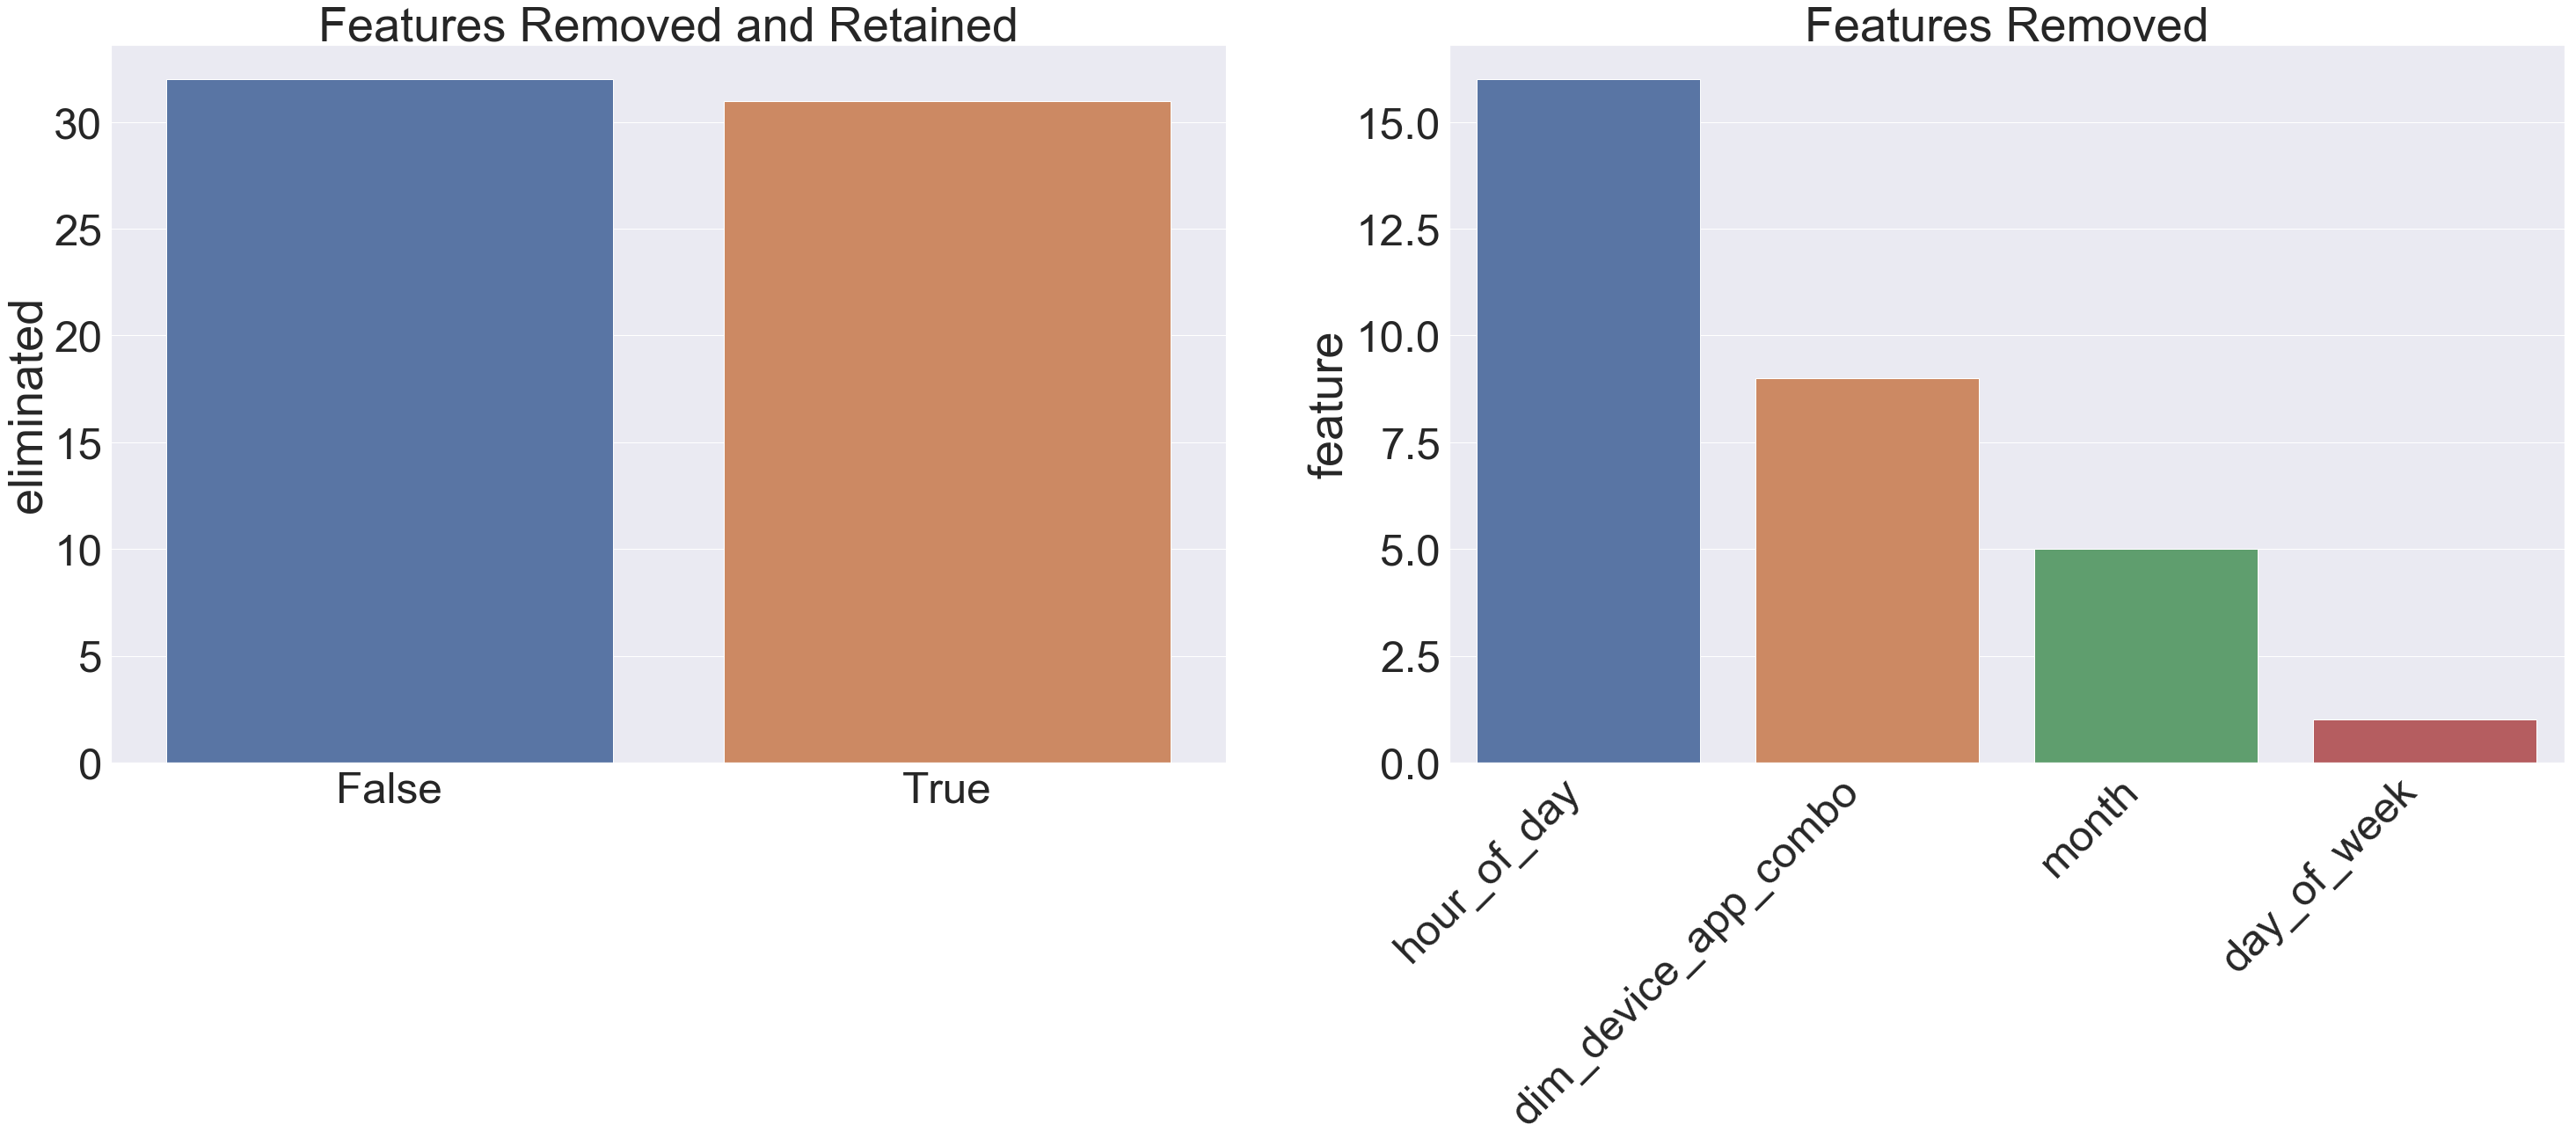

<Figure size 720x720 with 0 Axes>

In [470]:
# create df of the feature coefficients
one_hot_features =\
    pd.Series(
        cv_model\
        .best_estimator_\
        .named_steps['preprocessor']\
        .transformers_[1][1]\
        .named_steps['one_hot']\
        .get_feature_names())\
        .str.split('_')

categorical_df =\
    pd.DataFrame().assign(
    
        feature=one_hot_features.apply(lambda x: x[0]).map(categorical_feature_dict),
        dummy_value=one_hot_features.apply(lambda x: x[1]),
             
    )

categorical_df['reference_level'] = categorical_df.feature.map(reference_level_dict).astype('str')

categorical_df['model_feature'] =\
    categorical_df.feature.str.cat(categorical_df.dummy_value,'-')\
     .str.cat(categorical_df.reference_level, ' (') + ')'

numeric_df =\
    pd.DataFrame({'feature': numeric_features,
                 'dummy_value': np.repeat(np.nan, len(numeric_features)),
                 'model_feature': numeric_features})

model_features_df = pd.concat([numeric_df, categorical_df], ignore_index=True)

model_features_df =\
    model_features_df.assign(
    
        is_numeric_feature=model_features_df.dummy_value.isnull(),
        coefficient=cv_model.best_estimator_.named_steps['model'].coef_[0],
        importance=np.abs(cv_model.best_estimator_.named_steps['model'].coef_[0])
    )

model_features_df['is_positive'] = model_features_df.coefficient > 0
model_features_df['scaled_importance'] = model_features_df.importance / model_features_df.importance.max() * 100
model_features_df['eliminated'] = model_features_df.coefficient == 0

# data for plots
feature_statuses = model_features_df.eliminated.value_counts()
features_removed = model_features_df.loc[model_features_df.eliminated]['feature'].value_counts()

# plots
fig, axes = plt.subplots(ncols=2, figsize=(50, 15), sharey=False) 
sns.set(font_scale=4.5)
plt.figure(figsize=(10, 10))
sns.barplot(x=feature_statuses.index,
            y=feature_statuses,
            ax=axes[0])\
            .set_title('Features Removed and Retained')

g = sns.barplot(x=features_removed.index,
            y=features_removed,
            ax=axes[1])\
            .set_title('Features Removed')

a = axes[1].set_xticklabels(
    axes[1].get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
)

### Feature Importance

The final plot below shows the scaled importance of the top 15 model features (the absolute value of the model coefficients). The features with a positive effect on conversion are in green, and the features in red had a negative effect. The reference levels for categorical variables are shown within the parentheses and are the most frequent value in the feature.

- `sent_message` and `did_search` were the most important features and had positive effects on `sent_booking_request`. This confirms what the correlation plot indicated and makes sense from a practical perspective.

- `dim_session_number` had the largest negative effect on conversion. The size of its effect was about 40% of the `sent_message` effect.

- The `year` 2015 had a negative effect relative to the 2014 reference level.

- Desktop users on Chrome, Firefox and Safari were more likely to convert relative to the iPhone device and app.

- The effect of the `session_minutes` is surprisingly small. However, the `sent_message` and `did_search` features likely account for the effects of longer sessions.


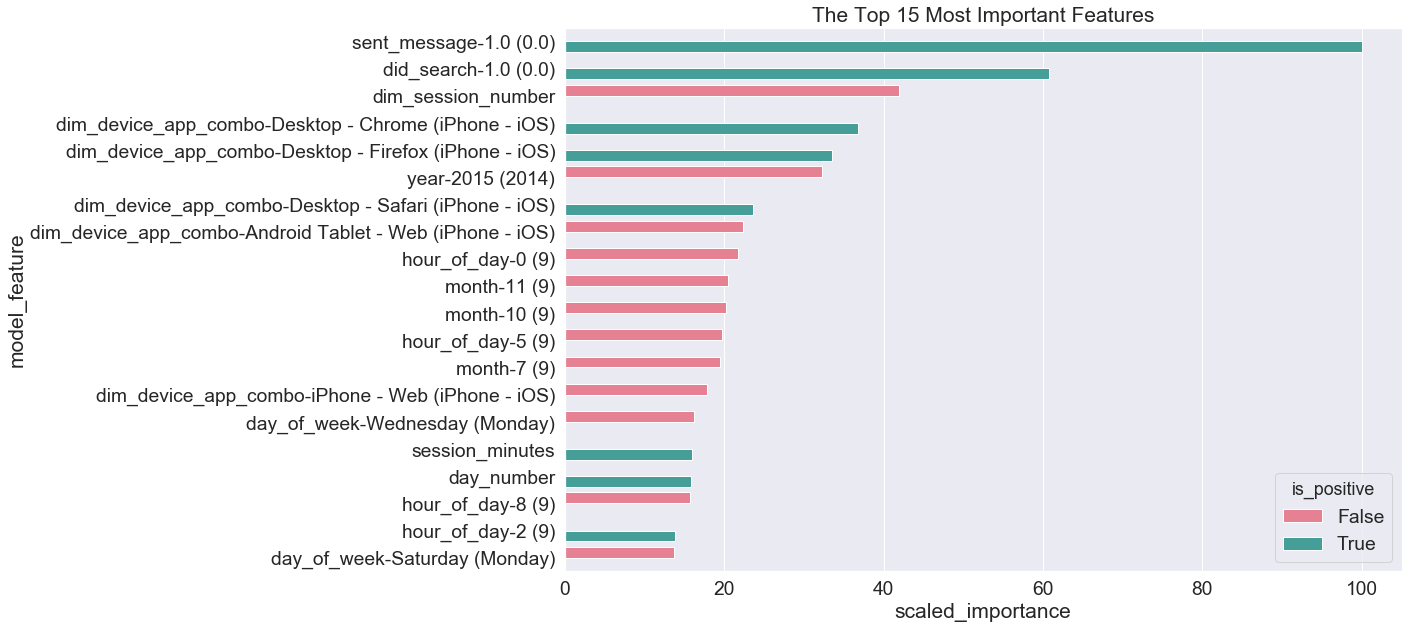

In [482]:
# plot data
top_features_df =\
    model_features_df\
    .sort_values('scaled_importance', ascending=False)\
    .nlargest(20, 'scaled_importance')\
    [['model_feature', 'scaled_importance', 'is_positive']]\
    .reset_index(drop=True)

# plot
sns.set(font_scale=1.75)
plt.figure(figsize=(15, 10))
g = sns.barplot(x='scaled_importance', 
            y='model_feature', 
            hue='is_positive', 
            palette="husl", 
            data=top_features_df)\
            .set_title('The Top 15 Most Important Features')

# Conclusions

Firstly, the moderately low F1 score indicates that the features in the model explain relatively little of the differences between converting and not converting. One would want to consider adding more features, like location, more customer purchase history and the number of results returned by the searches.

Secondly, while I could have used a more sophicated model like gradient boosting machines or neural networks, this would sacrifice the interpretabiity of the model results. I would not be able to easily show which features had positive or negative effects on conversion, and I would not know the true and independent effects of the features due to collinearity.

Lastly, the iPhone device/app combo are the most common way customers are visiting AirBnB. However, this combo is underperforming in conversion relative to the desktop web browsers. Based upon this limited dataset, I would recommend that the business invest more resources in making the iPhone app best-in-class in order to maximize conversion.

